In [1]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
output_dir = pathlib.Path('DMRCluster/')

## Gene meta

In [3]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

tf_genes = pd.read_csv(
    '/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv',
    index_col=0)
tf_genes = set(','.join(tf_genes['EnsemblID'].dropna()).split(','))
gene_meta['is_tf'] = gene_meta.index.map(lambda i: i.split('.')[0] in tf_genes)

zfp_pattern = r'Zfp\d+'
p = re.compile(zfp_pattern)
gene_meta.loc[gene_meta['gene_name'].apply(lambda i: p.search(i) is not None), 'is_tf'] = True
tf_gene_names = set(gene_meta[gene_meta['is_tf']]['gene_name'].tolist())

## Only plot useful gene
- Assigned to node
- Not overlap to other protein coding, those small non-coding or pseudo gene is actually partial signal for larger genes


In [4]:
def check_inclusive_gene(start, end, chrom_df):
    # assume df is in same chrom
    return any((chrom_df['start'] < start) & (chrom_df['end'] > end))

In [5]:
is_inclusive_genes = []
for chrom, sub_df in gene_meta.groupby('chrom'):
    print(chrom)
    judge = sub_df.apply(lambda i: check_inclusive_gene(i['start'], i['end'], sub_df), axis=1)
    is_inclusive_genes.append(judge)
# If True, means it is a small gene that's fully included into other gene's gene body
is_inclusive_genes = pd.concat(is_inclusive_genes)
non_inclusive_genes = is_inclusive_genes[~is_inclusive_genes].index

chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chrM
chrX
chrY


## Load DMR cluster data

In [6]:
cluster_profiles = list(output_dir.glob('chr*/*DMR_cluster.msg'))
total_profiles = []
for p in cluster_profiles:
    gene_id = '.'.join(p.name.split('.')[:2])
    if gene_id not in non_inclusive_genes:
        continue

    df = pd.read_msgpack(p)
    df['gene_id'] = '.'.join(p.name.split('.')[:2])
    total_profiles.append(df.reset_index())

total_profiles = pd.concat(total_profiles).reset_index(drop=True)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
dmr_detail_profiles = list(output_dir.glob('chr*/*DMR_detail.msg'))
n = 0
total_detail_profiles = []
for p in dmr_detail_profiles:
    n += 1
    if n % 500 == 0:
        print(n)
    gene_id = '.'.join(p.name.split('.')[:2])
    if gene_id not in non_inclusive_genes:
        continue

    df = pd.read_msgpack(p)
    df['gene_id'] = gene_id
    total_detail_profiles.append(df.reset_index())

total_detail_profiles = pd.concat(total_detail_profiles).reset_index(drop=True)

total_detail_profiles = total_detail_profiles[total_detail_profiles['gene_id'].isin(non_inclusive_genes)].copy()

500


In [7]:
print(total_profiles.shape)
total_profiles.head()

(91775, 450)


,leiden,Corr,reldist_tss,in_gene_body,is_dna_te,is_line_te,is_ltr_te,is_sine_te,in_intron,in_exon,...,ATACPeak.EP_Adcy8,ATACPeak.D1L-PAL_Plcxd3,ATACPeak.PAL-Inh_Onecut2,ATACPeak.LSX-Inh_Foxp2,ATACPeak.LSX-Inh_Enox1,ATACPeak.LSX-Inh_Dock10,ATACPeak.LSX-Inh_Nxph1,ATACPeak.LSX-Inh_Zeb2,ATACPeak.LSX-Inh_Lats2,gene_id
0,0,0.502214,0.406780,0.911602,0.016575,0.005525,0.022099,0.182320,0.895028,0.049724,...,0.049724,0.033149,0.038674,0.077348,0.077348,0.077348,0.077348,0.077348,0.077348,ENSMUSG00000029705.17
1,1,0.017539,0.377557,0.069620,0.037975,0.031646,0.139241,0.417722,0.063291,0.012658,...,0.025316,0.000000,0.012658,0.012658,0.012658,0.012658,0.012658,0.012658,0.012658,ENSMUSG00000029705.17
2,2,0.028028,0.547248,0.089172,0.012739,0.006369,0.108280,0.420382,0.089172,0.019108,...,0.006369,0.006369,0.006369,0.006369,0.006369,0.006369,0.006369,0.006369,0.006369,ENSMUSG00000029705.17
3,3,0.373747,0.506764,0.946667,0.013333,0.026667,0.040000,0.286667,0.946667,0.093333,...,0.006667,0.000000,0.006667,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,ENSMUSG00000029705.17
4,4,0.114463,0.402983,0.325758,0.007576,0.030303,0.007576,0.113636,0.325758,0.007576,...,0.143939,0.075758,0.189394,0.272727,0.272727,0.272727,0.272727,0.272727,0.272727,ENSMUSG00000029705.17


## Exclude gene that's fully included in other gene's gene body
- These gene are usually predicted gene or miRNA, which located inside a protein coding gene, the "in_gene_body" value is usually low for these gene, which is confusing, just because these gene is part of a larger marker gene.

- a better approach would be do sequence clsutering using mCH level of samples first, then do corr with whatever genome chunks 

In [8]:
gene_meta = gene_meta.loc[total_profiles['gene_id'].unique()].copy()

In [9]:
total_profiles['MaxHypoDMRPortion'] = total_profiles.loc[:,
                                                         total_profiles.columns
                                                         .str.startswith(
                                                             'HypoDMR')].max(
                                                                 axis=1)
total_profiles['MeanDMRRate'] = total_profiles.loc[:,
                                                   total_profiles.columns.str.
                                                   startswith('DMRRate')].mean(
                                                       axis=1)
total_profiles['MeanATACPeakPortion'] = total_profiles.loc[:,
                                                   total_profiles.columns.str.
                                                   startswith('ATACPeak')].mean(
                                                       axis=1)
total_profiles['gene_name'] = total_profiles['gene_id'].map(gene_meta['gene_name'])
total_profiles['is_tf'] = total_profiles['gene_name'].isin(tf_gene_names)

## Signature DMR Cluster

In [28]:
signature_dmr_judge = total_profiles['Corr'] > 0.3
signature_dmr = total_profiles.loc[signature_dmr_judge].copy()

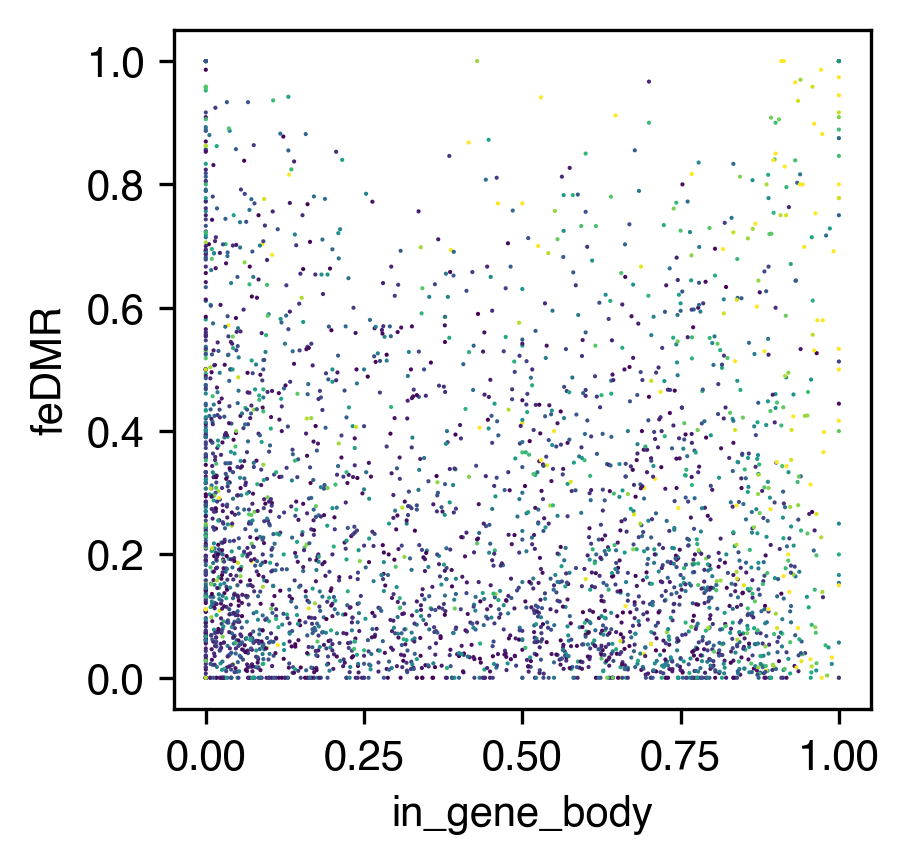

In [34]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

sns.scatterplot(ax=ax, data=signature_dmr, x='in_gene_body', y='feDMR', 
                hue='Corr', hue_norm=(0.3, 0.7), palette='viridis', 
                s=1, # size='Corr', size_norm=(0.3, 0.7), sizes=(0, 5),
                legend=False, linewidth=0)

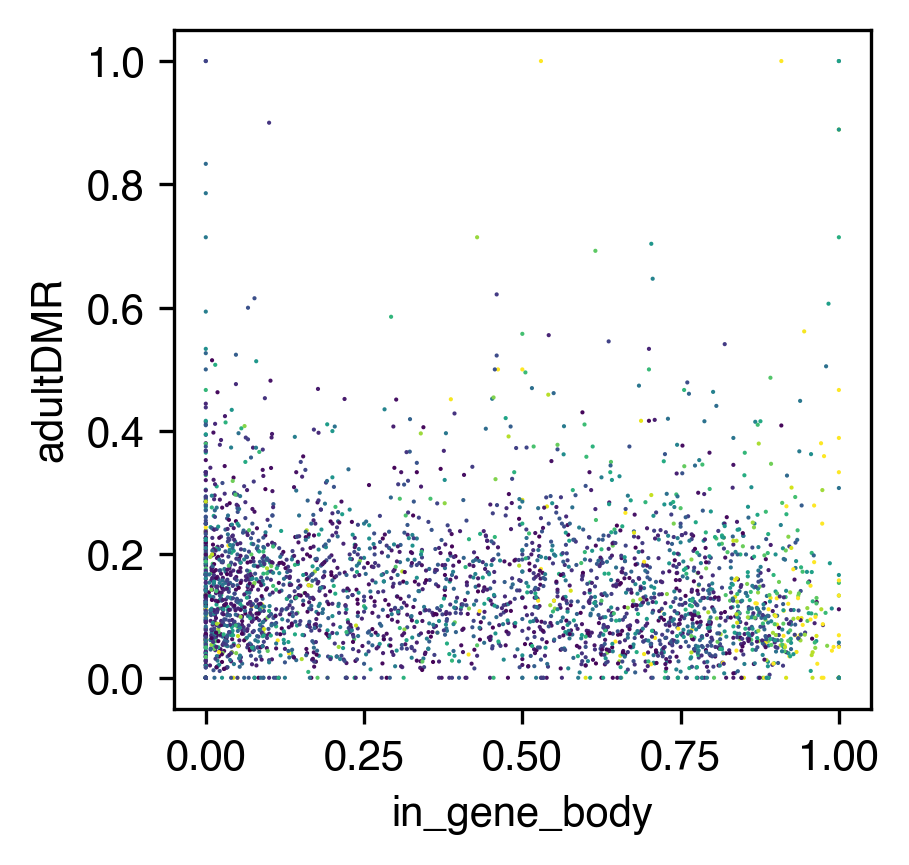

In [35]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

sns.scatterplot(ax=ax, data=signature_dmr, x='in_gene_body', y='adultDMR', 
                hue='Corr', hue_norm=(0.3, 0.7), palette='viridis', 
                s=1, # size='Corr', size_norm=(0.3, 0.7), sizes=(0, 5),
                legend=False, linewidth=0)

(0, 1)

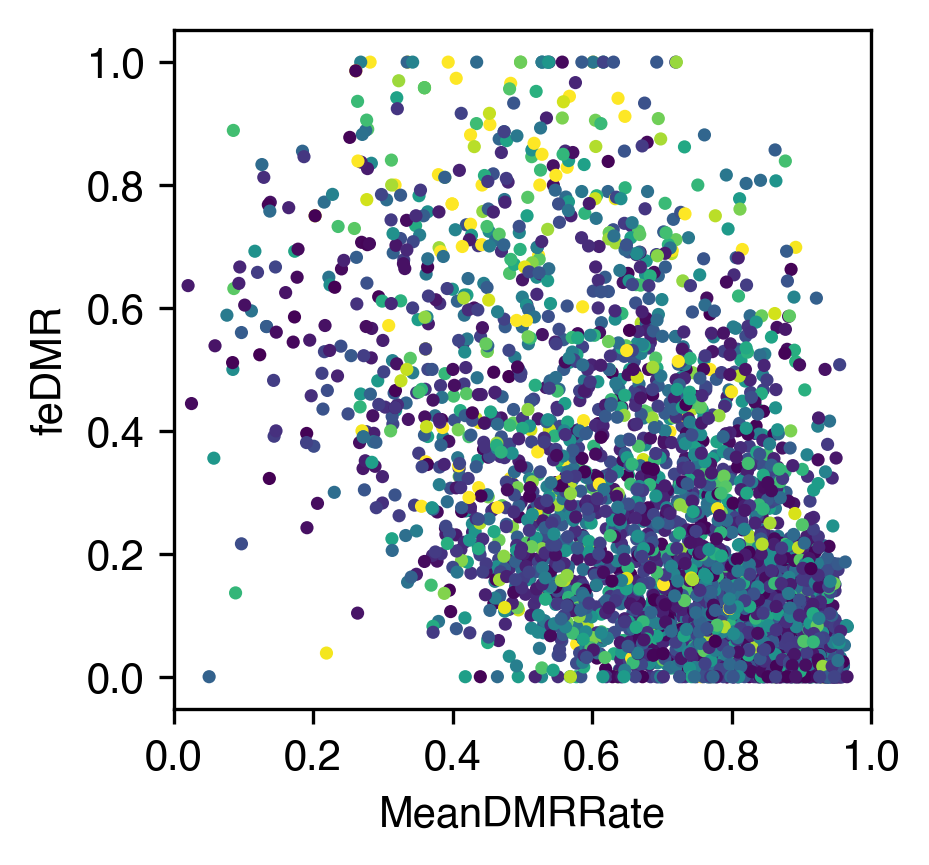

In [70]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

gene_id = gene_name_to_id['Msi2']
sns.scatterplot(ax=ax, 
                data=signature_dmr, 
                x='MeanDMRRate', y='feDMR', 
                hue='Corr', hue_norm=(0.3, 0.7), palette='viridis', 
                s=10, # size='Corr', size_norm=(0.3, 0.7), sizes=(0, 5),
                legend=False, linewidth=0)

ax.set_xlim(0, 1)

In [30]:
((signature_dmr['in_gene_body'] > 0.5) & (signature_dmr['feDMR'] > 0.5)).sum(), \
((signature_dmr['in_gene_body'] < 0.5) & (signature_dmr['feDMR'] > 0.5)).sum(), \
((signature_dmr['in_gene_body'] > 0.5) & (signature_dmr['feDMR'] < 0.5)).sum(), \
((signature_dmr['in_gene_body'] < 0.5) & (signature_dmr['feDMR'] < 0.5)).sum(), 

(211, 317, 1172, 1541)

In [62]:
signature_dmr[(signature_dmr['in_gene_body'] > 0.5) & 
              (signature_dmr['feDMR'] > 0.5)]['gene_name'].value_counts()[:50]

Nfib             5
Zeb2             4
Tcf4             4
Msi2             4
Fyn              4
Nfix             3
Bcl11b           3
Runx1t1          3
Celf4            3
Pbx1             3
Ttc28            2
Zfhx3            2
Bach2            2
Tshz3            2
C530008M17Rik    2
Lncppara         2
Gng2             2
Nrxn2            2
Zfp608           2
Prdm16           2
Zmiz1            2
Map1b            2
Dscaml1          2
Zfp536           2
Sall1            2
Meis2            2
Cacna2d2         2
Basp1            2
Man1c1           2
Bcl11a           2
Ephb2            2
Tshz1            2
Mir124-2hg       1
Wscd1            1
Klhl13           1
Gdpd5            1
Inka2            1
Mgll             1
Boc              1
Sipa1l3          1
Arid1b           1
Ablim1           1
C130071C03Rik    1
Klf7             1
Abat             1
Htr7             1
Syngr1           1
Kalrn            1
Vav2             1
Cadm1            1
Name: gene_name, dtype: int64

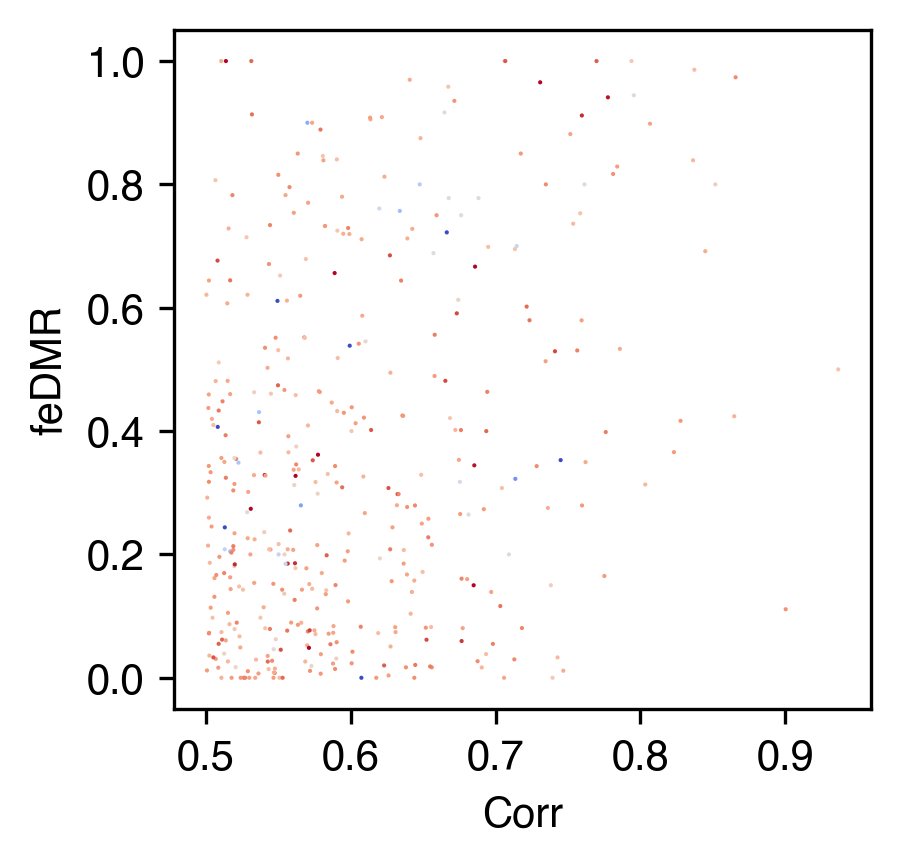

In [13]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

sns.scatterplot(ax=ax, data=signature_dmr, x='Corr', y='feDMR', hue='reldist_tss',
                hue_norm=(-1, 1), palette='coolwarm', legend=False,
                s=1, linewidth=0)

In [114]:
signature_dmr['gene_name'] = signature_dmr['gene_id'].map(gene_meta['gene_name'])
total_profiles['gene_name'] = total_profiles['gene_id'].map(gene_meta['gene_name'])

In [96]:
for g in signature_dmr[signature_dmr['feDMR'] > 0.5]['gene_name'].value_counts().index.tolist():
    print(g)

Tcf4
Zeb2
Nfib
Bcl11b
Nfix
Zfp608
Meis2
Cacna2d2
Tshz1
Pbx1
Bcl11a
Msi2
Dscaml1
Tshz3
Sall1
Nrxn2
Mtcl1
Srcin1
Sox1ot
Btg1
Tox3
Fyn
Tmem151b
Celf4
Ttc28
Abat
Mir124-2hg
Zbtb16
Fam222a
Ccdc85c
Dlx1as
Slit1
Mn1
Gm16121
Gng2
Vat1
Srgap3
Inka2
Grik3
Nr4a2
Iqsec3
Pou3f2
Adrb1
Foxo6
Pantr1
Wscd1
Irs2
Epha4
Lncppara
Trib2
Cables1
Rnd3
Pitpnb
Pax6
Efhd2
Pcdh7
Nectin1
Gse1
Enc1
Rara
Efnb2
Rab3c
Gm2164
Gm3764
Cadm4
Kirrel
Mpped1
Lats2
Ablim1
Cux2
Runx1t1
Zmiz1
Sez6
Prdm16
Sez6l
Tmem44
Rgma
Klf6
Nrxn3
Slc6a1
Vav2
Emx1
Osbpl9
Lhx2
Sel1l3
Shisa6
Boc
Rgs8
Nav2
Metap1d
Zfp536


In [111]:
pd.Series(signature_dmr['gene_name'].unique()).isin(tf_gene_names).sum()

48

In [113]:
signature_dmr['gene_name'].unique().size

269

In [115]:
pd.Series(total_profiles['gene_name'].unique()).isin(tf_gene_names).sum()

364

In [116]:
total_profiles['gene_name'].unique().size

8110

## Fetal DMR Cluster

In [62]:
fe_dmr_judge = total_profiles['feDMR'] > 0.5
fe_dmr = total_profiles.loc[fe_dmr_judge].copy()

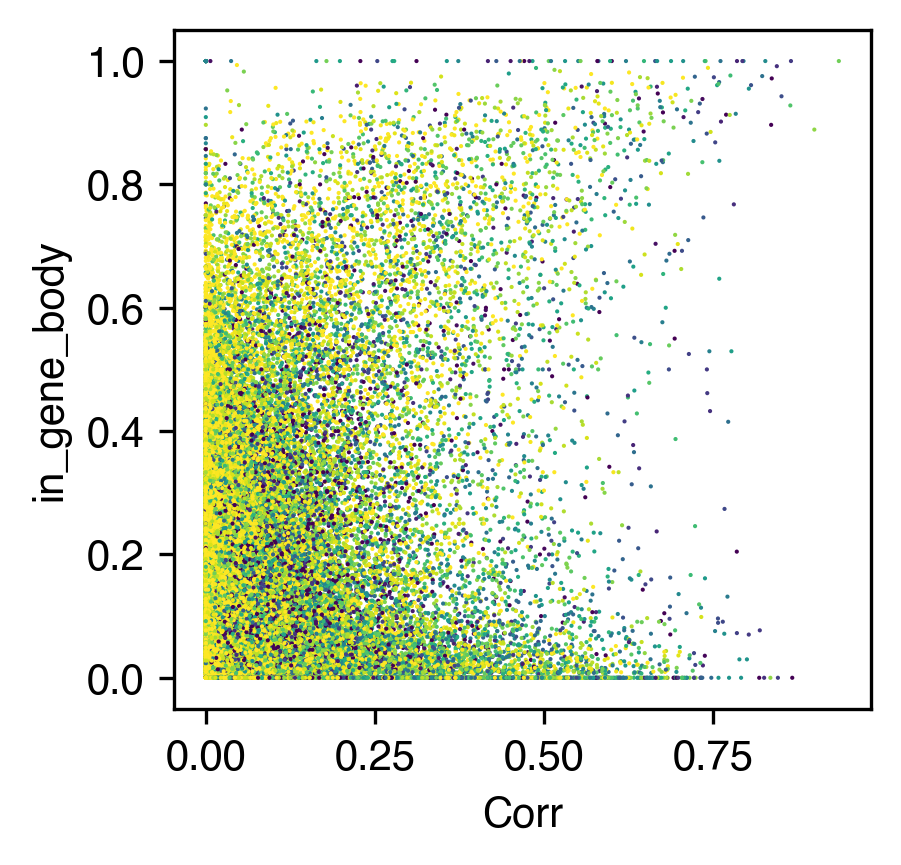

In [18]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

sns.scatterplot(ax=ax, data=total_profiles, x='Corr', y='in_gene_body', hue='MeanDMRRate',
                hue_norm=(0.3, 0.9), palette='viridis', legend=False,
                s=1, linewidth=0)


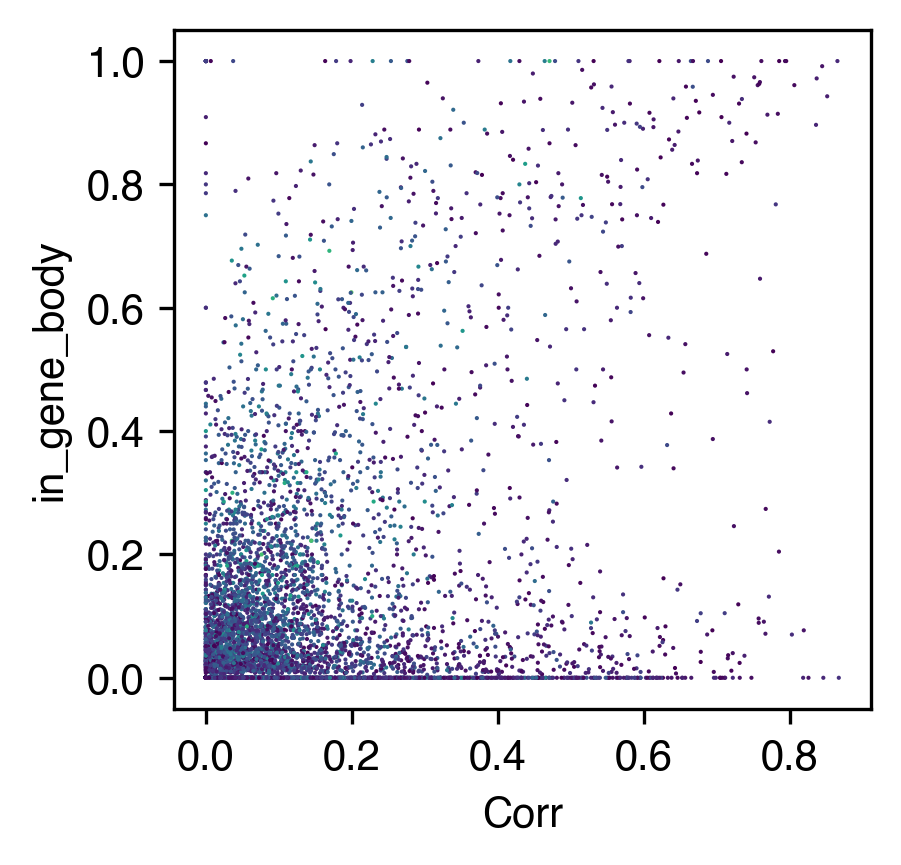

In [66]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

sns.scatterplot(ax=ax, data=fe_dmr, x='Corr', y='in_gene_body', hue='MeanATACPeakPortion',
                hue_norm=(0, 1), palette='viridis', legend=False,
                s=1, linewidth=0)


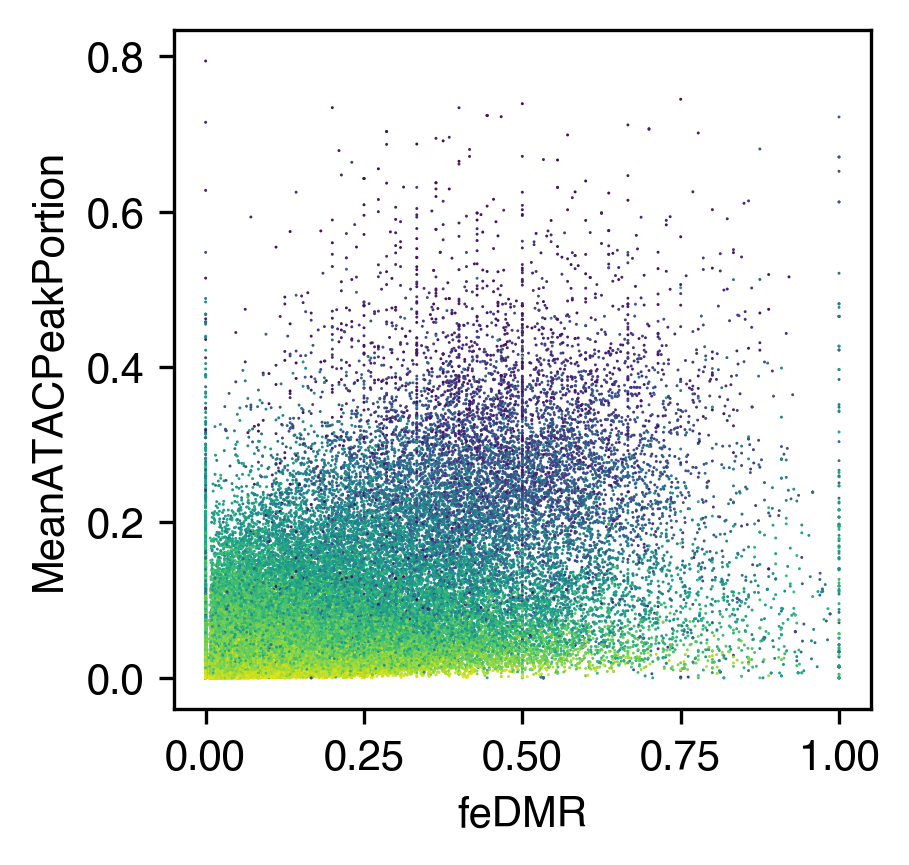

In [71]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
sns.scatterplot(ax=ax, data=total_profiles, x='feDMR', y='MeanATACPeakPortion', hue='MeanDMRRate',
                hue_norm=(0, 1), palette='viridis', legend=False,
                s=0.5, linewidth=0)